In [11]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [ ]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=8, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [3]:
# model_dir_name = 'inception-bn-blue'
# download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
# model_name = 'inception-bn-blue'
# model_iteration = 0
# output_symbol_name = 'flatten_output'
# output_dim = 1024
# mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# # Reference on how to predict with mxnet model:
# # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
# model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
# flatten_output = model0.get_internals()[output_symbol_name]
# # if HOST_ID == 'workstation':
# # model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
# # else:
# model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# # Increase batch_size to 500 does not save any time.
# batch_size = 256
# model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
# model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

In [13]:
dataset_settings = read_csv(DATASET_SETTINGS_CSV, header=0, index_col=0)
dataset_settings

classes      network_model            stain  \
dataset_id                                                                  
20                                NaN       Inception-BN            nissl   
21                                NaN       Inception-BN            nissl   
22                                NaN       Inception-BN            nissl   
23          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
24          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
25          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
26                                NaN  inception-bn-blue            nissl   
27                                NaN  inception-bn-blue            nissl   
28                                NaN  inception-bn-blue            nissl   
29                                neg  inception-bn-blue            nissl   
30          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
31          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
32          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
33          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
34          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
35          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
36          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
37          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
38          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
39          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
40          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
41          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
50                                NaN  inception-bn-blue  neurotrace_blue   
51                                NaN  inception-bn-blue  neurotrace_blue   
60                                NaN                NaN            nissl   
61                                NaN                NaN            nissl   
62                                NaN                NaN            nissl   
63          pos/surPos/surNoclass/neg                NaN            nissl   
64          pos/surPos/surNoclass/neg                NaN            nissl   
65          pos/surPos/surNoclass/neg                NaN            nissl   
66          pos/surPos/surNoclass/neg                NaN            nissl   
67          pos/surPos/surNoclass/neg                NaN            nissl   
68          pos/surPos/surNoclass/neg                NaN            nissl   
70          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
71          pos/surPos/surNoclass/neg  inception-bn-blue  neurotrace_blue   
72          pos/surPos/surNoclass/neg                NaN            nissl   
73          pos/surPos/surNoclass/neg                NaN            nissl   
74          pos/surPos/surNoclass/neg                NaN            nissl   
75          pos/surPos/surNoclass/neg                NaN            nissl   
76          pos/surPos/surNoclass/neg                NaN            nissl   
77          pos/surPos/surNoclass/neg                NaN            nissl   
90                                NaN                NaN            nissl   
92                                NaN                NaN            nissl   
93                                NaN                NaN            nissl   
94                                NaN                NaN            nissl   
95                                NaN                NaN            nissl   
96                                NaN                NaN            nissl   
97                                NaN                NaN            nissl   
98                                NaN                NaN            nissl   
99                                NaN                NaN            nissl   

           margins_um  nu

In [15]:
classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)
classifier_settings

model  margin_um       train_set_id  \
classifier_id                                                            
30                                    lr        500              20/21   
31                                    lr        500              21/22   
32                                    lr        500              20/22   
33                                   gb1        500              20/21   
34                                   gb1        500              21/22   
35                                   gb1        500              20/22   
36                                   gb1        500              23/24   
37                                    lr        500              23/24   
38                                    lr        500        23/24/27/28   
39                                    lr        200        30/31/27/28   
40                                    lr       1000        33/34/27/28   
41                                    lr        500        36/37/27/28   
42                                    lr        500        39/40/27/28   
50                                    lr        500  27/28/29/60/61/62   
70             inception-bn-blue-softmax        500              60/61   
71             inception-bn-blue-softmax        500           60/61/62   
72                                    lr        500           66/67/68   
73                                    lr        500           66/67/68   
74                                    lr        500           72/73/74   
75                                    lr        500           72/73/74   
76                                    lr        500           75/76/77   
80                                    lr        500              23/24   
81                                    lr        500              23/24   
82                                    lr        500              23/24   
83                                    lr        500              23/24   
84                                    lr        500              23/24   
95                                   gb2        500                 93   
96                                   gb2        500                 95   
97                                   gb2        500                 97   
98                                   gb2        500                 99   
99                                    lr        500                 99   

                             neg_composition  sample_weighting  \
classifier_id                                                    
30                      neg_has_all_surround               NaN   
31                      neg_has_all_surround               NaN   
32                      neg_has_all_surround               NaN   
33                      neg_has_all_surround               NaN   
34                      neg_has_all_surround               NaN   
35                      neg_has_all_surround               NaN   
36                      neg_has_all_surround               NaN   
37                      neg_has_all_surround               NaN   
38             neg_has_surround_and_negative               NaN   
39             neg_has_surround_and_negative               NaN   
40             neg_has_surround_and_negative               NaN   
41             neg_has_surround_and_negative               NaN   
42             neg_has_surround_and_negative               NaN   
50             neg_has_surround_and_negative               NaN   
70                      neg_has_all_surround               NaN   
71                      neg_has_all_surround               NaN   
72             neg_has_surround_and_negative               NaN   
73                      neg_has_all_surround               NaN   
74                      neg_has_all_surround               NaN   
75             neg_has_surround_and_negative               NaN   
76             neg_has_surround_and_negative               NaN   
80                      neg_has_all_surround               NaN   
81      

In [16]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

# Train new classifiers

In [19]:
classifier_id = 76
classifier_properties = classifier_settings.loc[classifier_id]

margin_um = classifier_properties['margin_um']
feature_classifier_model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']
svm_id = int(classifier_properties['svm_id'])

## load features and train, multiple structures

In [ ]:
# for structure in all_known_structures:
for structure in ['5N',
 '6N',
 '7N',
 '7n',
 'Amb',
 'LC',
 'LRt',
 'Pn',
 'Tz',
 'VLL',
 'RMC',
 'SNC',
 'SNR',
 '3N',
 '4N',
 'Sp5I',
 'Sp5O',
 'Sp5C',
 'PBG',
 '10N',
 'VCA',
 'VCP',
 'DC',
 'AP',
 '12N',
 'RtTg',
 'SC',
 'IC']:
    
    # Determine which labels to load.

    structures_to_sample = [structure]
    # structures_to_sample = all_known_structures
    # structures_to_sample = ['Pn']

    negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

    margins_to_sample = [margin_um]
    surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                                 for m in margins_to_sample
                                 for s in structures_to_sample 
                                 for surr_l in all_known_structures
                                 if surr_l != s]
    surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                                 for m in margins_to_sample
                                 for s in structures_to_sample]

    if neg_composition == 'neg_has_everything_else':
        labels_to_sample = structures_to_sample + negative_labels_to_sample
    elif neg_composition == 'neg_has_only_surround_noclass':
        labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
    elif neg_composition == 'neg_has_all_surround':
        labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']
    elif neg_composition == 'neg_has_surround_and_negative':
        labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample
    else:
        raise Exception("neg_composition %s not recognized" % neg_composition)
    
    ######################
    
    training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
    training_features, training_addresses = load_datasets_bp(training_set_ids, labels_to_sample=labels_to_sample)
    
    ########################
    
    labels_found = training_features.keys()
    structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}
    
    ######################
    
    print structure

    #############################
    ## Define Positive Samples ##
    #############################

    features_pos = training_features[structure]
    n_pos = len(features_pos)
    print n_pos, 'positive examples'

    #############################
    ## Define Negative Samples ##
    #############################

    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
        for surr_s in all_known_structures:
            c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    elif neg_composition == 'neg_has_surround_and_negative':
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
        for surr_s in all_known_structures:
            c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
        neg_classes += [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])

    n_neg = len(features_neg)
    print n_neg, 'negative examples'

    ###########################
    ## Define Sample Weights ##
    ###########################

    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])

        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None

    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]

    #     n_train = len(train_labels0)
    #     ri = np.random.choice(range(n_train), size=100, replace=False)
    #     train_data = train_data0[ri]
    #     train_labels = train_labels0[ri]

    #####################################
    ## Define feature_classifier_model ##
    #####################################

    if feature_classifier_model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

    elif feature_classifier_model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)


    elif feature_classifier_model == 'lin_svc_calib':

        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)


    elif feature_classifier_model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

    elif feature_classifier_model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')

    elif feature_classifier_model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')


    else:
        sys.stderr.write('Setting is not recognized.\n')

    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
    create_parent_dir_if_not_exists(clf_fp)
    joblib.dump(clf, clf_fp)
    upload_to_s3(clf_fp)
    
    from sklearn.metrics import accuracy_score
    train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
    print train_acc

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_6N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_6N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_6N.bp"
rm -rf "/shared/CSHL_classifier

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_5N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_5N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_5N_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_7

5N
3000 positive examples
6021 negative examples


Fitting classifier: 3.02 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/5N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/5N_clf_setting_76.dump"
0.924509477885
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_6N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_6N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_6N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_6N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_6N_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_7

6N
861 positive examples
6355 negative examples


Fitting classifier: 1.71 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/6N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/6N_clf_setting_76.dump"
0.978381374723
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7N_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_7

7N
3000 positive examples
6038 negative examples


Fitting classifier: 3.10 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/7N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/7N_clf_setting_76.dump"
0.918234122593
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7n.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7n_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_7n_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_7n_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_7n_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_7

7n
3000 positive examples
6331 negative examples


Fitting classifier: 3.01 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/7n_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/7n_clf_setting_76.dump"
0.957775158075
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Amb.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Amb_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Amb_surround_500_Sp5C.bp" "/shared/CSHL_classifi

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Amb_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/d

Amb
1569 positive examples
6221 negative examples


Fitting classifier: 1.85 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Amb_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Amb_clf_setting_76.dump"
0.97188703466
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LC_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LC_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LC_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_7

LC
3000 positive examples
6000 negative examples


Fitting classifier: 2.74 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/LC_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/LC_clf_setting_76.dump"
0.922555555556
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_LRt_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_LRt_surround_500_Sp5C.bp" "/shared/CSHL_classifi

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_LRt_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/d

LRt
3000 positive examples
6182 negative examples


Fitting classifier: 3.44 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/LRt_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/LRt_clf_setting_76.dump"
0.889457634502
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Pn_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Pn_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Pn_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/datase

Pn
3000 positive examples
9073 negative examples


Fitting classifier: 5.61 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Pn_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Pn_clf_setting_76.dump"
0.905988569535
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Tz_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Tz_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Tz_surround_500_VLL.bp" "/shared/CSHL_classifiers/datasets/datase

Tz
3000 positive examples
7596 negative examples


Fitting classifier: 3.65 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Tz_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Tz_clf_setting_76.dump"
0.959607399018
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VLL.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VLL_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VLL_surround_500_Sp5C.bp" "/shared/CSHL_classifi

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VLL_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/

VLL
3000 positive examples
6111 negative examples


Fitting classifier: 3.98 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/VLL_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/VLL_clf_setting_76.dump"
0.875205795193
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RMC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RMC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RMC_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RMC_surround_500_noclass.bp"
RMC
3000 positive examples
6001 negative examples


Fitting classifier: 2.83 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/RMC_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/RMC_clf_setting_76.dump"
0.897344739473
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNC_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNC_surround_500_noclass.bp"
SNC
3000 positive examples
9000 negative examples


Fitting classifier: 4.23 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/SNC_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/SNC_clf_setting_76.dump"
0.900583333333
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNR.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SNR_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SNR_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SNR_surround_500_noclass.bp"
SNR
3000 positive examples
9221 negative examples


Fitting classifier: 5.55 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/SNR_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/SNR_clf_setting_76.dump"
0.88298829883
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_3N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_3N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_3N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_3N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_

3N
3000 positive examples
6248 negative examples


Fitting classifier: 3.05 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/3N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/3N_clf_setting_76.dump"
0.927551903114
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_4N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_4N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_4N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_4N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_

4N
476 positive examples
6721 negative examples


Fitting classifier: 1.72 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/4N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/4N_clf_setting_76.dump"
0.986800055579
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebra

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5I_surround_500_12N.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5I_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_Pn.bp" "/shared/CSHL_classifiers/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5I_surround_500_noclass.bp"
Sp5I
3000 positive examples
12000 negative examples


Fitting classifier: 7.36 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Sp5I_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Sp5I_clf_setting_76.dump"
0.883733333333
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mous

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5O_surround_500_12N.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5O_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_Pn.bp" "/shared/CSHL_classifiers/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5O_surround_500_noclass.bp"
Sp5O
3000 positive examples
9000 negative examples


Fitting classifier: 6.12 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Sp5O_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Sp5O_clf_setting_76.dump"
0.845083333333
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mous

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_Sp5C_surround_500_12N.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_Sp5C_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_Pn.bp" "/shared/CSHL_classifiers/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_Sp5C_surround_500_noclass.bp"
Sp5C
3000 positive examples
9038 negative examples


Fitting classifier: 5.72 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/Sp5C_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/Sp5C_clf_setting_76.dump"
0.864678518026
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_PBG.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebraina

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_PBG_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_PBG_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_PBG_surround_500_noclass.bp"
PBG
2715 positive examples
6454 negative examples


Fitting classifier: 3.03 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/PBG_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/PBG_clf_setting_76.dump"
0.945686552514
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_10N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_10N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_10N_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_10N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_10N_surround_500_noclass.bp"
10N
2605 positive examples
9367 negative examples


Fitting classifier: 3.59 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/10N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/10N_clf_setting_76.dump"
0.962746408286
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCA.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCA_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCA_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCA_surround_500_noclass.bp"
VCA
3000 positive examples
12000 negative examples


Fitting classifier: 5.77 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/VCA_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/VCA_clf_setting_76.dump"
0.911066666667
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatl

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_VCP_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_VCP_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_VCP_surround_500_noclass.bp"
VCP
3000 positive examples
12000 negative examples


Fitting classifier: 6.22 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/VCP_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/VCP_clf_setting_76.dump"
0.893866666667
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_DC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_DC_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_DC_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_DC_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_

DC
3000 positive examples
12000 negative examples


Fitting classifier: 5.84 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/DC_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/DC_clf_setting_76.dump"
0.912733333333
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_AP_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/C

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_AP_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets/data

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_AP_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_AP_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_

AP
3000 positive examples
6343 negative examples


Fitting classifier: 2.25 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/AP_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/AP_clf_setting_76.dump"
0.973777159371
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_12N_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_12N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datasets

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_12N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_12N_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/

12N
3000 positive examples
8621 negative examples


Fitting classifier: 3.61 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/12N_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/12N_clf_setting_76.dump"
0.950520609242
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mouseb

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_VCP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_VCP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_VCP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_RtTg_surround_500_AP.bp" "/shared/CSHL_classifiers/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_3N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_3N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_3N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_RtTg_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LC.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_Pn.bp" "/shared/CSHL_classifiers/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_noclass.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_noclass.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_RtTg_surround_500_noclass.bp"
RtTg
3000 positive examples
9818 negative examples


Fitting classifier: 5.88 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/RtTg_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/RtTg_clf_setting_76.dump"
0.855749726946
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-da

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_SC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_7

rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_4N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_4N.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_4N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_Sp5I.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_Sp5I.bp" "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_Sp5I.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_76"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_76/patch_features_SC_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/d

rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_LRt.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_LRt.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_LRt.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_Pn.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_Pn.bp" "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_Pn.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_Tz.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_77"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_77/patch_features_SC_surround_500_Tz.bp" "/shared/CSHL_classifiers/datasets/dataset_

SC
3000 positive examples
9000 negative examples


Fitting classifier: 6.17 seconds


aws s3 cp "/shared/CSHL_classifiers/setting_76/classifiers/SC_clf_setting_76.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_76/classifiers/SC_clf_setting_76.dump"
0.81675
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_IC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_negative.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_IC_negative.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_negative.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_cla

rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_AP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_AP.bp" "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_AP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_12N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_75"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_75/patch_features_IC_surround_500_12N.bp" "/shared/CSHL_classifiers/datasets/dataset_7

## load training features, one structure

In [12]:
# Determine which labels to load.

structures_to_sample = [structure]
# structures_to_sample = all_known_structures
# structures_to_sample = ['Pn']

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin_um]
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in all_known_structures
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_surround_and_negative':
    labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample
else:
    raise Exception("neg_composition %s not recognized" % neg_composition)

In [13]:
training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
training_features, training_addresses = load_datasets_bp(training_set_ids, labels_to_sample=labels_to_sample)

rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_5N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_5N.bp" "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_5N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_6N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_6N.bp" "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_6N.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_7N.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_7N.bp" "/shared/CSHL_classifiers/datasets/dat

rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_outerContour.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_outerContour.bp" "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_outerContour.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_SC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_SC.bp" "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_SC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_IC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_72"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_72/patch_features_10N_surround_500_IC.bp" "/shared

rm -rf "/shared/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_VCP.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_73"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_VCP.bp" "/shared/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_VCP.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_DC.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_73"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_DC.bp" "/shared/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_DC.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_RtTg.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_73"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_73/patch_features_10N_surround_500_RtTg.bp" "/shared/CSHL_classifiers/datas

rm -rf "/shared/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5O.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_74"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5O.bp" "/shared/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5O.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5C.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_74"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5C.bp" "/shared/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_Sp5C.bp"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_PBG.bp" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_74"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_74/patch_features_10N_surround_500_PBG.bp" "/shared/CSHL_classifier

## or load training data as images

In [ ]:
training_set_ids = [60, 61, 62]
training_patches, _ = load_dataset_images(training_set_ids, labels_to_sample=labels_to_sample)

In [57]:
train_variants = range(0, 8)

In [213]:
training_features = {}
for s, ps in training_patches.iteritems():
    feats = []
    for v in train_variants:
        ps_var = rotate_all_patches_variant(ps, variant=v)
        feats_var = convert_image_patches_to_features(patches=ps_var, model=model, mean_img=mean_img, batch_size=batch_size)
        feats.append(feats_var)
    feats_arr = np.concatenate(feats)
    training_features[s] = feats_arr

In [215]:
neg_features, _ = load_datasets([27,28,29], labels_to_sample=negative_labels_to_sample)

rm -rf "/shared/CSHL_classifiers/datasets/dataset_27/patch_features.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_27"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_27/patch_features.hdf" "/shared/CSHL_classifiers/datasets/dataset_27/patch_features.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_28/patch_addresses.pkl" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_28"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_28/patch_addresses.pkl" "/shared/CSHL_classifiers/datasets/dataset_28/patch_addresses.pkl"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_28/patch_features.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_28"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_28/patch_features.hdf" "/shared/CSHL_classifiers/datasets/dataset_28/patch_features.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_29/patch_addresses.pkl" && mkdir -p "/shared/CSHL_classifiers/datasets/

In [216]:
training_features['VCA_negative'] = neg_features['VCA_negative']

## do training, one structure

In [14]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

In [16]:
structure = '10N'
print structure

#############################
## Define Positive Samples ##
#############################

features_pos = training_features[structure]
n_pos = len(features_pos)
print n_pos, 'positive examples'

#############################
## Define Negative Samples ##
#############################

if neg_composition == 'neg_has_only_surround_noclass':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
elif neg_composition == 'neg_has_all_surround':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    for surr_s in all_known_structures:
        c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
        if c in labels_found:
            neg_classes.append(c)
elif neg_composition == 'neg_has_everything_else':
    neg_classes = [structure + '_negative']
elif neg_composition == 'neg_has_surround_and_negative':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    for surr_s in all_known_structures:
        c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
        if c in labels_found:
            neg_classes.append(c)
    neg_classes += [structure + '_negative']
else:
    raise Exception('neg_composition %s is not recognized.' % neg_composition)

features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])

n_neg = len(features_neg)
print n_neg, 'negative examples'

###########################
## Define Sample Weights ##
###########################

if sample_weighting == 'weighted':
    neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])

    sample_weights_neg = np.ones((n_neg,))
    sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
    sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
else:
    sample_weights = None

###########################################################################################

train_data = np.r_[features_pos, features_neg]
train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                     -np.ones((features_neg.shape[0], ))]

#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

#####################################
## Define feature_classifier_model ##
#####################################

if feature_classifier_model == 'lr':
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                             fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                             verbose=0, warm_start=False, n_jobs=1)

elif feature_classifier_model == 'lin_svc':
    clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
              probability=True, tol=0.001, cache_size=1000, max_iter=-1,
          decision_function_shape=None, random_state=None)


elif feature_classifier_model == 'lin_svc_calib':

    sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                            C=1.0, multi_class='ovr', 
                            fit_intercept=True, intercept_scaling=1, max_iter=100)
    clf = CalibratedClassifierCV(sv_uncalibrated)


elif feature_classifier_model == 'xgb1':
    clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                        silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                        min_child_weight=20, max_delta_step=0, subsample=.8, 
                        colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

elif feature_classifier_model == 'gb1':
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                     subsample=1., criterion='friedman_mse', 
                                     min_samples_split=50, min_samples_leaf=20, 
                                     min_weight_fraction_leaf=0.0, max_depth=3, 
                                     min_impurity_split=1e-07, init=None, random_state=None, 
                                     max_features=None, verbose=1, max_leaf_nodes=None, 
                                     warm_start=False, presort='auto')

elif feature_classifier_model == 'gb2':
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                     subsample=1., criterion='friedman_mse', 
                                     min_samples_split=50, min_samples_leaf=20, 
                                     min_weight_fraction_leaf=0.0, max_depth=5, 
                                     min_impurity_split=1e-07, init=None, random_state=None, 
                                     max_features=None, verbose=1, max_leaf_nodes=None, 
                                     warm_start=False, presort='auto')


else:
    sys.stderr.write('Setting is not recognized.\n')

t = time.time()    
clf.fit(train_data, train_labels, sample_weight=sample_weights)
sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

# clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
# create_parent_dir_if_not_exists(clf_fp)
# joblib.dump(clf, clf_fp)

# upload_to_s3(clf_fp)

10N
125040 positive examples
305616 negative examples


Fitting classifier: 375.17 seconds


In [17]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
print train_acc

0.903096671125


In [18]:
svm_id = 999
available_classifiers = {svm_id: {structure: clf}}

# Load a set of pre-trained classifiers

In [104]:
model_name = 'inception-bn-blue'
classifier_id = 38

classifier_properties = classifier_settings.loc[classifier_id]
assert dataset_settings.loc[int(classifier_properties['train_set_id'].split('/')[0])]['network_model'] == model_name
svm_id = int(classifier_properties['svm_id'])

########################

available_classifiers = {svm_id: DataManager.load_classifiers(classifier_id=svm_id)}

rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifi

rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump"


# Load another set of pre-trained classifiers

In [6]:
from sklearn.externals import joblib

available_classifiers = {}

for classifier_id in [72, 73, 74, 75]:

    clf_allClasses = {}
    for structure in all_known_structures:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
        download_from_s3(clf_fp)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    classifier_properties = classifier_settings.loc[classifier_id]
    svm_id = int(classifier_properties['svm_id'])
    
    available_classifiers[svm_id] = clf_allClasses

rm -rf "/shared/CSHL_classifiers/setting_72/classifiers/sp5_clf_setting_72.dump" && mkdir -p "/shared/CSHL_classifiers/setting_72/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_72/classifiers/sp5_clf_setting_72.dump" "/shared/CSHL_classifiers/setting_72/classifiers/sp5_clf_setting_72.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_72/classifiers/outerContour_clf_setting_72.dump" && mkdir -p "/shared/CSHL_classifiers/setting_72/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_72/classifiers/outerContour_clf_setting_72.dump" "/shared/CSHL_classifiers/setting_72/classifiers/outerContour_clf_setting_72.dump"


Classifier for outerContour is not found.


rm -rf "/shared/CSHL_classifiers/setting_73/classifiers/sp5_clf_setting_73.dump" && mkdir -p "/shared/CSHL_classifiers/setting_73/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_73/classifiers/sp5_clf_setting_73.dump" "/shared/CSHL_classifiers/setting_73/classifiers/sp5_clf_setting_73.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_73/classifiers/outerContour_clf_setting_73.dump" && mkdir -p "/shared/CSHL_classifiers/setting_73/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_73/classifiers/outerContour_clf_setting_73.dump" "/shared/CSHL_classifiers/setting_73/classifiers/outerContour_clf_setting_73.dump"


Classifier for outerContour is not found.


rm -rf "/shared/CSHL_classifiers/setting_74/classifiers/sp5_clf_setting_74.dump" && mkdir -p "/shared/CSHL_classifiers/setting_74/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_74/classifiers/sp5_clf_setting_74.dump" "/shared/CSHL_classifiers/setting_74/classifiers/sp5_clf_setting_74.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_74/classifiers/outerContour_clf_setting_74.dump" && mkdir -p "/shared/CSHL_classifiers/setting_74/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_74/classifiers/outerContour_clf_setting_74.dump" "/shared/CSHL_classifiers/setting_74/classifiers/outerContour_clf_setting_74.dump"


Classifier for outerContour is not found.


rm -rf "/shared/CSHL_classifiers/setting_75/classifiers/sp5_clf_setting_75.dump" && mkdir -p "/shared/CSHL_classifiers/setting_75/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_75/classifiers/sp5_clf_setting_75.dump" "/shared/CSHL_classifiers/setting_75/classifiers/sp5_clf_setting_75.dump"


Classifier for sp5 is not found.


rm -rf "/shared/CSHL_classifiers/setting_75/classifiers/outerContour_clf_setting_75.dump" && mkdir -p "/shared/CSHL_classifiers/setting_75/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_75/classifiers/outerContour_clf_setting_75.dump" "/shared/CSHL_classifiers/setting_75/classifiers/outerContour_clf_setting_75.dump"


Classifier for outerContour is not found.


# Predict for patches on example images.

In [96]:
structure = '10N'

In [97]:
structures = [structure]

In [98]:
# VCA is reasonable
# DC can only achieve 0.3 F1 score.

In [99]:
if structure == 'VCA':
    roi_xmin = 968 * 8
    roi_ymin = 827 * 8
    roi_w = 435 * 8
    roi_h = 357 * 8
    filenames = ['MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111'] # example for VCA
elif structure == '7N':
    roi_xmin = 850 * 8
    roi_ymin = 973 * 8
    roi_w = 562 * 8
    roi_h = 639 * 8
    filenames = ['MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155'] # example for 7N
elif structure == 'DC':
    roi_xmin = 912 * 8
    roi_ymin = 597 * 8
    roi_w = 694 * 8
    roi_h = 634 * 8
#     filenames = ['MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115']
    filenames = ['MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118']
elif structure == '10N':
#     roi_xmin = 1376 * 8
#     roi_ymin = 817 * 8
#     roi_w = 474 * 8
#     roi_h = 392 * 8
#     filenames = ['MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226']
#     filenames = ['MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227']
    filenames = ['MD658-F49-2017.04.05-03.36.45_MD658_2_0146']
    roi_xmin = 1498 * 8
    roi_ymin = 905 * 8
    roi_w = 360 * 8
    roi_h = 222 * 8
    stack = 'MD658'
    section_to_filename = metadata_cache['sections_to_filenames'][stack]

In [ ]:
windowing_id = 3

windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]
half_size = patch_size/2

grid_spec = (patch_size, spacing, w, h)

sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [100]:
# Variants in testing, then use the maximum
test_variants = range(0, 8)
# test_variants = range(0, 1)

# Test on one region

In [101]:
intensity_ranges = [(low, 0) for low in np.r_[np.arange(400, 2000, 100), -100, -200]]

In [102]:
sparse_grids_allSchemes_allFns_allStructs = {}
features_allSchemes_allFns_allStructs_allVariants = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [103]:
for fn in filenames:

    ####################

    t = time.time()
    mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, fn=fn)
    indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb, 
                                    bbox_lossless=(roi_xmin,roi_ymin,roi_w,roi_h))
    sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
    
    sparse_grids_allSchemes_allFns_allStructs[fn] = indices_roi

    n = len(indices_roi)
    sys.stderr.write('%d samples.\n' % n)

    ############################

    sample_locations_roi = sample_locations[indices_roi]

    ###########################

    t = time.time()
    img_blue = DataManager.load_image_v2(stack=stack, fn=fn, prep_id=2, resol='lossless')[..., 2]
    sys.stderr.write('Read: %.2f seconds\n' % (time.time() - t))
    
    for low, high in intensity_ranges:
#     for low, high in [(-200, 0)]:
        
        t = time.time()
        if low == -100:
            intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
            download_from_s3(intensity_mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(intensity_mapping_fp)
            img_blue_intensity_normalized = intensity_mapping_ntb_to_nissl[img_blue.astype(np.int)].astype(np.uint8)
        elif low == -200:
            intensity_mapping_ntb_to_nissl = np.loadtxt('/tmp/ntb_to_nissl_mapping.npy')
            img_blue_intensity_normalized = intensity_mapping_ntb_to_nissl[img_blue.astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized = rescale_intensity_v2(img_blue, low, high)
        sys.stderr.write('Adjust contrast: %.2f seconds\n' % (time.time() - t))

#         patches = np.array([img_blue_intensity_normalized[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224

        t = time.time()
        patches = extract_patches_given_locations(img=img_blue_intensity_normalized, 
                                                  locs=sample_locations_roi, 
                                                  patch_size=224)
        sys.stderr.write('Extract patches: %.2f seconds\n' % (time.time() - t))

#         extra_margin = 200
#         patches_enlarged = extract_patches_given_locations(img=img_blue_intensity_normalized, 
#                                                            locs=sample_locations_roi, 
#                                                            patch_size=224+2*extra_margin)            
        for variant in test_variants:
            
            t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
            patches_rotated = rotate_all_patches_variant(patches, variant=variant)
            sys.stderr.write('Variants: %.2f seconds\n' % (time.time() - t))

            #############################

            t1 = time.time()
            features = convert_image_patches_to_features(patches_rotated, model=model, 
                                                         mean_img=mean_img, 
                                                         batch_size=batch_size)

            features_allSchemes_allFns_allStructs_allVariants[(low, high)][fn][structure][variant] = features
            sys.stderr.write('Feature extraction: %.2f seconds\n' % (time.time() - t1))

            #################################
            
features_allSchemes_allFns_allStructs_allVariants.default_factory = None

rm -rf "/shared/CSHL_data_processed/MD658/MD658_prep2_thumbnail_mask/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD658/MD658_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_prep2_thumbnail_mask/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD658/MD658_prep2_thumbnail_mask/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
4984 samples.


rm -rf "/shared/CSHL_data_processed/MD658/MD658_prep2_lossless/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_lossless.tif" && mkdir -p "/shared/CSHL_data_processed/MD658/MD658_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_prep2_lossless/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_lossless.tif" "/shared/CSHL_data_processed/MD658/MD658_prep2_lossless/MD658-F49-2017.04.05-03.36.45_MD658_2_0146_prep2_lossless.tif"


Read: 25.78 seconds
Adjust contrast: 7.55 seconds
Extract patches: 0.10 seconds
Variants: 0.01 seconds
Feature extraction: 3.40 seconds
Variants: 0.00 seconds
Feature extraction: 3.31 seconds
Variants: 0.00 seconds
Feature extraction: 3.24 seconds
Variants: 0.00 seconds
Feature extraction: 3.30 seconds
Variants: 0.00 seconds
Feature extraction: 3.30 seconds
Variants: 0.00 seconds
Feature extraction: 3.33 seconds
Variants: 0.01 seconds
Feature extraction: 3.33 seconds
Variants: 0.01 seconds
Feature extraction: 3.34 seconds
Adjust contrast: 7.45 seconds
Extract patches: 0.10 seconds
Variants: 0.00 seconds
Feature extraction: 3.37 seconds
Variants: 0.00 seconds
Feature extraction: 3.33 seconds
Variants: 0.00 seconds
Feature extraction: 3.24 seconds
Variants: 0.00 seconds
Feature extraction: 3.31 seconds
Variants: 0.00 seconds
Feature extraction: 3.30 seconds
Variants: 0.00 seconds
Feature extraction: 3.34 seconds
Variants: 0.00 seconds
Feature extraction: 3.34 seconds
Variants: 0.00 secon

Feature extraction: 3.31 seconds
Variants: 0.00 seconds
Feature extraction: 3.35 seconds
Variants: 0.00 seconds
Feature extraction: 3.28 seconds
Variants: 0.00 seconds
Feature extraction: 3.34 seconds
Variants: 0.00 seconds
Feature extraction: 3.34 seconds
Variants: 0.00 seconds
Feature extraction: 3.36 seconds
Variants: 0.00 seconds
Feature extraction: 3.36 seconds
Variants: 0.01 seconds
Feature extraction: 3.36 seconds
Adjust contrast: 2.23 seconds
Extract patches: 0.08 seconds
Variants: 0.00 seconds
Feature extraction: 3.36 seconds
Variants: 0.00 seconds
Feature extraction: 3.36 seconds
Variants: 0.00 seconds
Feature extraction: 3.27 seconds
Variants: 0.00 seconds
Feature extraction: 3.33 seconds
Variants: 0.00 seconds
Feature extraction: 3.32 seconds
Variants: 0.00 seconds
Feature extraction: 3.35 seconds
Variants: 0.01 seconds
Feature extraction: 3.33 seconds
Variants: 0.00 seconds
Feature extraction: 3.33 seconds


In [104]:
# conditions = [(72, 'test_no_rot'), (72, 'test_with_rot'),
#               (73, 'test_no_rot'), (73, 'test_with_rot'),
#             (74, 'test_no_rot'), (74, 'test_with_rot'),
#              (75, 'test_no_rot'), (75, 'test_with_rot')]

conditions = [(72, 'test_with_rot'),
              (73, 'test_with_rot'),
            (74, 'test_with_rot'),
            (75, 'test_with_rot')]

In [105]:
sparse_scores_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for condition in conditions:
    
    if condition[1] == 'test_no_rot':
        test_variants = range(1)
    elif condition[1] == 'test_with_rot':
        test_variants = range(8)
    
    svm_id = condition[0]
        
    for fn in filenames:
        for low, high in intensity_ranges:
#         for low, high in [(-200,0)]:

            probs_allClasses_allVariations = []

            for variant in test_variants:
                
                def clf_predict(stack, fn):
                    clf_allClasses_ = available_classifiers[svm_id]
                    probs_allClasses = {}
        #             for structure, clf in clf_allClasses_.iteritems():
                    for s in structures:
                        clf = clf_allClasses_[s]
                        features = features_allSchemes_allFns_allStructs_allVariants[(low, high)][fn][s][variant]
                        probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
                        probs_allClasses[s] = probs
                    return probs_allClasses

                t = time.time()

                probs_allClasses = clf_predict(stack=stack, fn=fn)
                probs_allClasses_allVariations.append(probs_allClasses)

                #         probs_allFns_allClasses[fn] = clf_predict(stack=stack, fn=fn)

                #         pool = Pool(NUM_CORES/2)
                #         probs_allFns_allClasses = dict(zip(filenames, pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)))
                #         pool.close()
                #         pool.join()
                sys.stderr.write('Classifier predict: %.2f s\n' % (time.time()-t))

#             probs_allClasses = defaultdict(dict)
    #         best_variation = {}
            for s in structures:
                pvs = [probs_allClasses_allVariations[v][s] for v in test_variants]
    #             best_variation[s] = np.argmax(pvs, axis=0)
                sparse_scores_allSchemes_allFns_allStructs_allConditions[(low,high)][fn][s][condition] = np.max(pvs, axis=0)    

sparse_scores_allSchemes_allFns_allStructs_allConditions.default_factory = None

Classifier predict: 0.02 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
C

Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
C

In [106]:
X = defaultdict(dict)
for intens, x in sparse_scores_allSchemes_allFns_allStructs_allConditions.iteritems():
    if intens == (-200, 0): # don't use the manually matched scheme
        continue
    for cond, scores in x[fn][structure].iteritems():
        X[cond][intens] = scores
        
best_scheme = {}
best_sparse_scores = {}
for cond, y in X.iteritems():
    ii, ss = zip(*y.items())
    ss = np.array(ss)
    ii = list(ii)
    ssargmax = np.argmax(ss, axis=0)
    best_scheme[cond] = [ii[i] for i in ssargmax]
    best_sparse_scores[cond] = np.array([ss[ii.index(i), p] for p, i in enumerate(best_scheme[cond])])

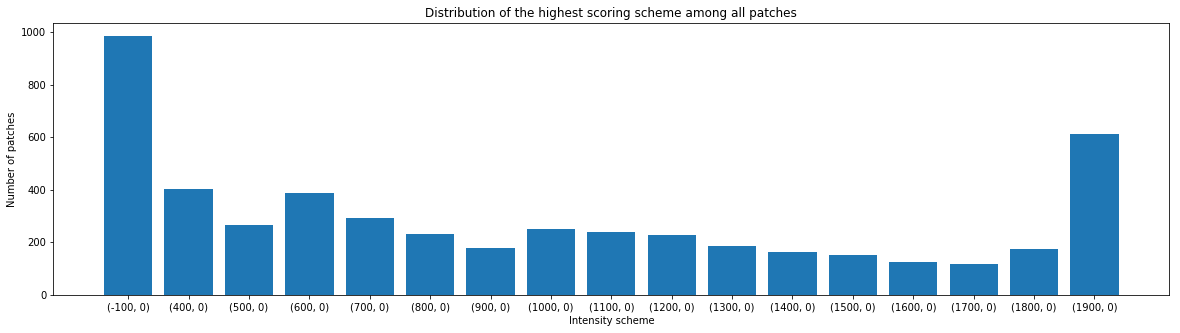

In [108]:
from collections import Counter
schemes, counts = zip(*sorted(Counter(sorted(best_scheme[(72, 'test_with_rot')])).items()))

plt.figure(figsize=(20,5));
plt.bar(range(len(schemes)), counts);
plt.xticks(range(len(schemes)), schemes);
plt.title('Distribution of the highest scoring scheme among all patches');
plt.ylabel('Number of patches');
plt.xlabel('Intensity scheme');

In [110]:
scoremap_viz_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [111]:
conditions = [(72, 'test_with_rot'),
              (73, 'test_with_rot')]

In [112]:
downscale = 32
img_blue_intensity_normalized = {}

for fn in filenames:
    
    for intens in intensity_ranges:
        low, high = intens
        if low == -100:
            intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
            download_from_s3(intensity_mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(intensity_mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)].astype(np.int)].astype(np.uint8)
        elif low == -200:
            intensity_mapping_ntb_to_nissl = np.loadtxt('/tmp/ntb_to_nissl_mapping.npy')
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)].astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized[intens] = rescale_intensity_v2(img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)], low, high)
    
    for structure in structures:
        for intens in intensity_ranges:
            for cond in conditions:

                def resample_scoremap(fn, s):
                    
                    downscaled_grid_y = np.arange(0, h, downscale)
                    downscaled_grid_x = np.arange(0, w, downscale)
                    downscaled_ny = len(downscaled_grid_y)
                    downscaled_nx = len(downscaled_grid_x)

                    sparse_scores = sparse_scores_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] 

                    f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                    a = (sample_locations_roi - half_size)/spacing
                    f_grid[a[:,1], a[:,0]] = sparse_scores

                    yinterps = (downscaled_grid_y - half_size)/float(spacing)
                    xinterps = (downscaled_grid_x - half_size)/float(spacing)

                    points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                    coord = np.c_[points_y.flat, points_x.flat]
                    f_interp = map_coordinates(f_grid, coord.T, order=1)
                    f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                    scoremap = f_interp_2d.astype(np.float16)
                        
                    return scoremap

#                 t = time.time()
                scoremap = resample_scoremap(fn, structure)
                #         pool = Pool(NUM_CORES/2)
                #         # pool = Pool(1)
                #         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
                #         pool.close()
                #         pool.join()
#                 sys.stderr.write('Resample scoremap: %.2f seconds\n' % (time.time() - t)) 

                #########################
    
                def save_scoremap(structure):
                    scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[intens], 
                                                       in_downscale=1, stack=stack, fn=fn, structure=structure,
                                                       scoremap=scoremap[roi_ymin/32:(roi_ymin+roi_h)/32,
                                                                           roi_xmin/32:(roi_xmin+roi_w)/32],
                                                      in_scoremap_downscale=32,
                                                      out_downscale=8, label_text=str(structure), 
                                                      cmap_name= 'jet')
                #         pool = Pool(NUM_CORES)
                #         structures = scoremaps_allClasses.keys()
                #         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
                #         pool.close()
                #         pool.join()
                    return scoremap_viz

                t = time.time()

                for s in structures:
                    scoremap_viz_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] = save_scoremap(s)

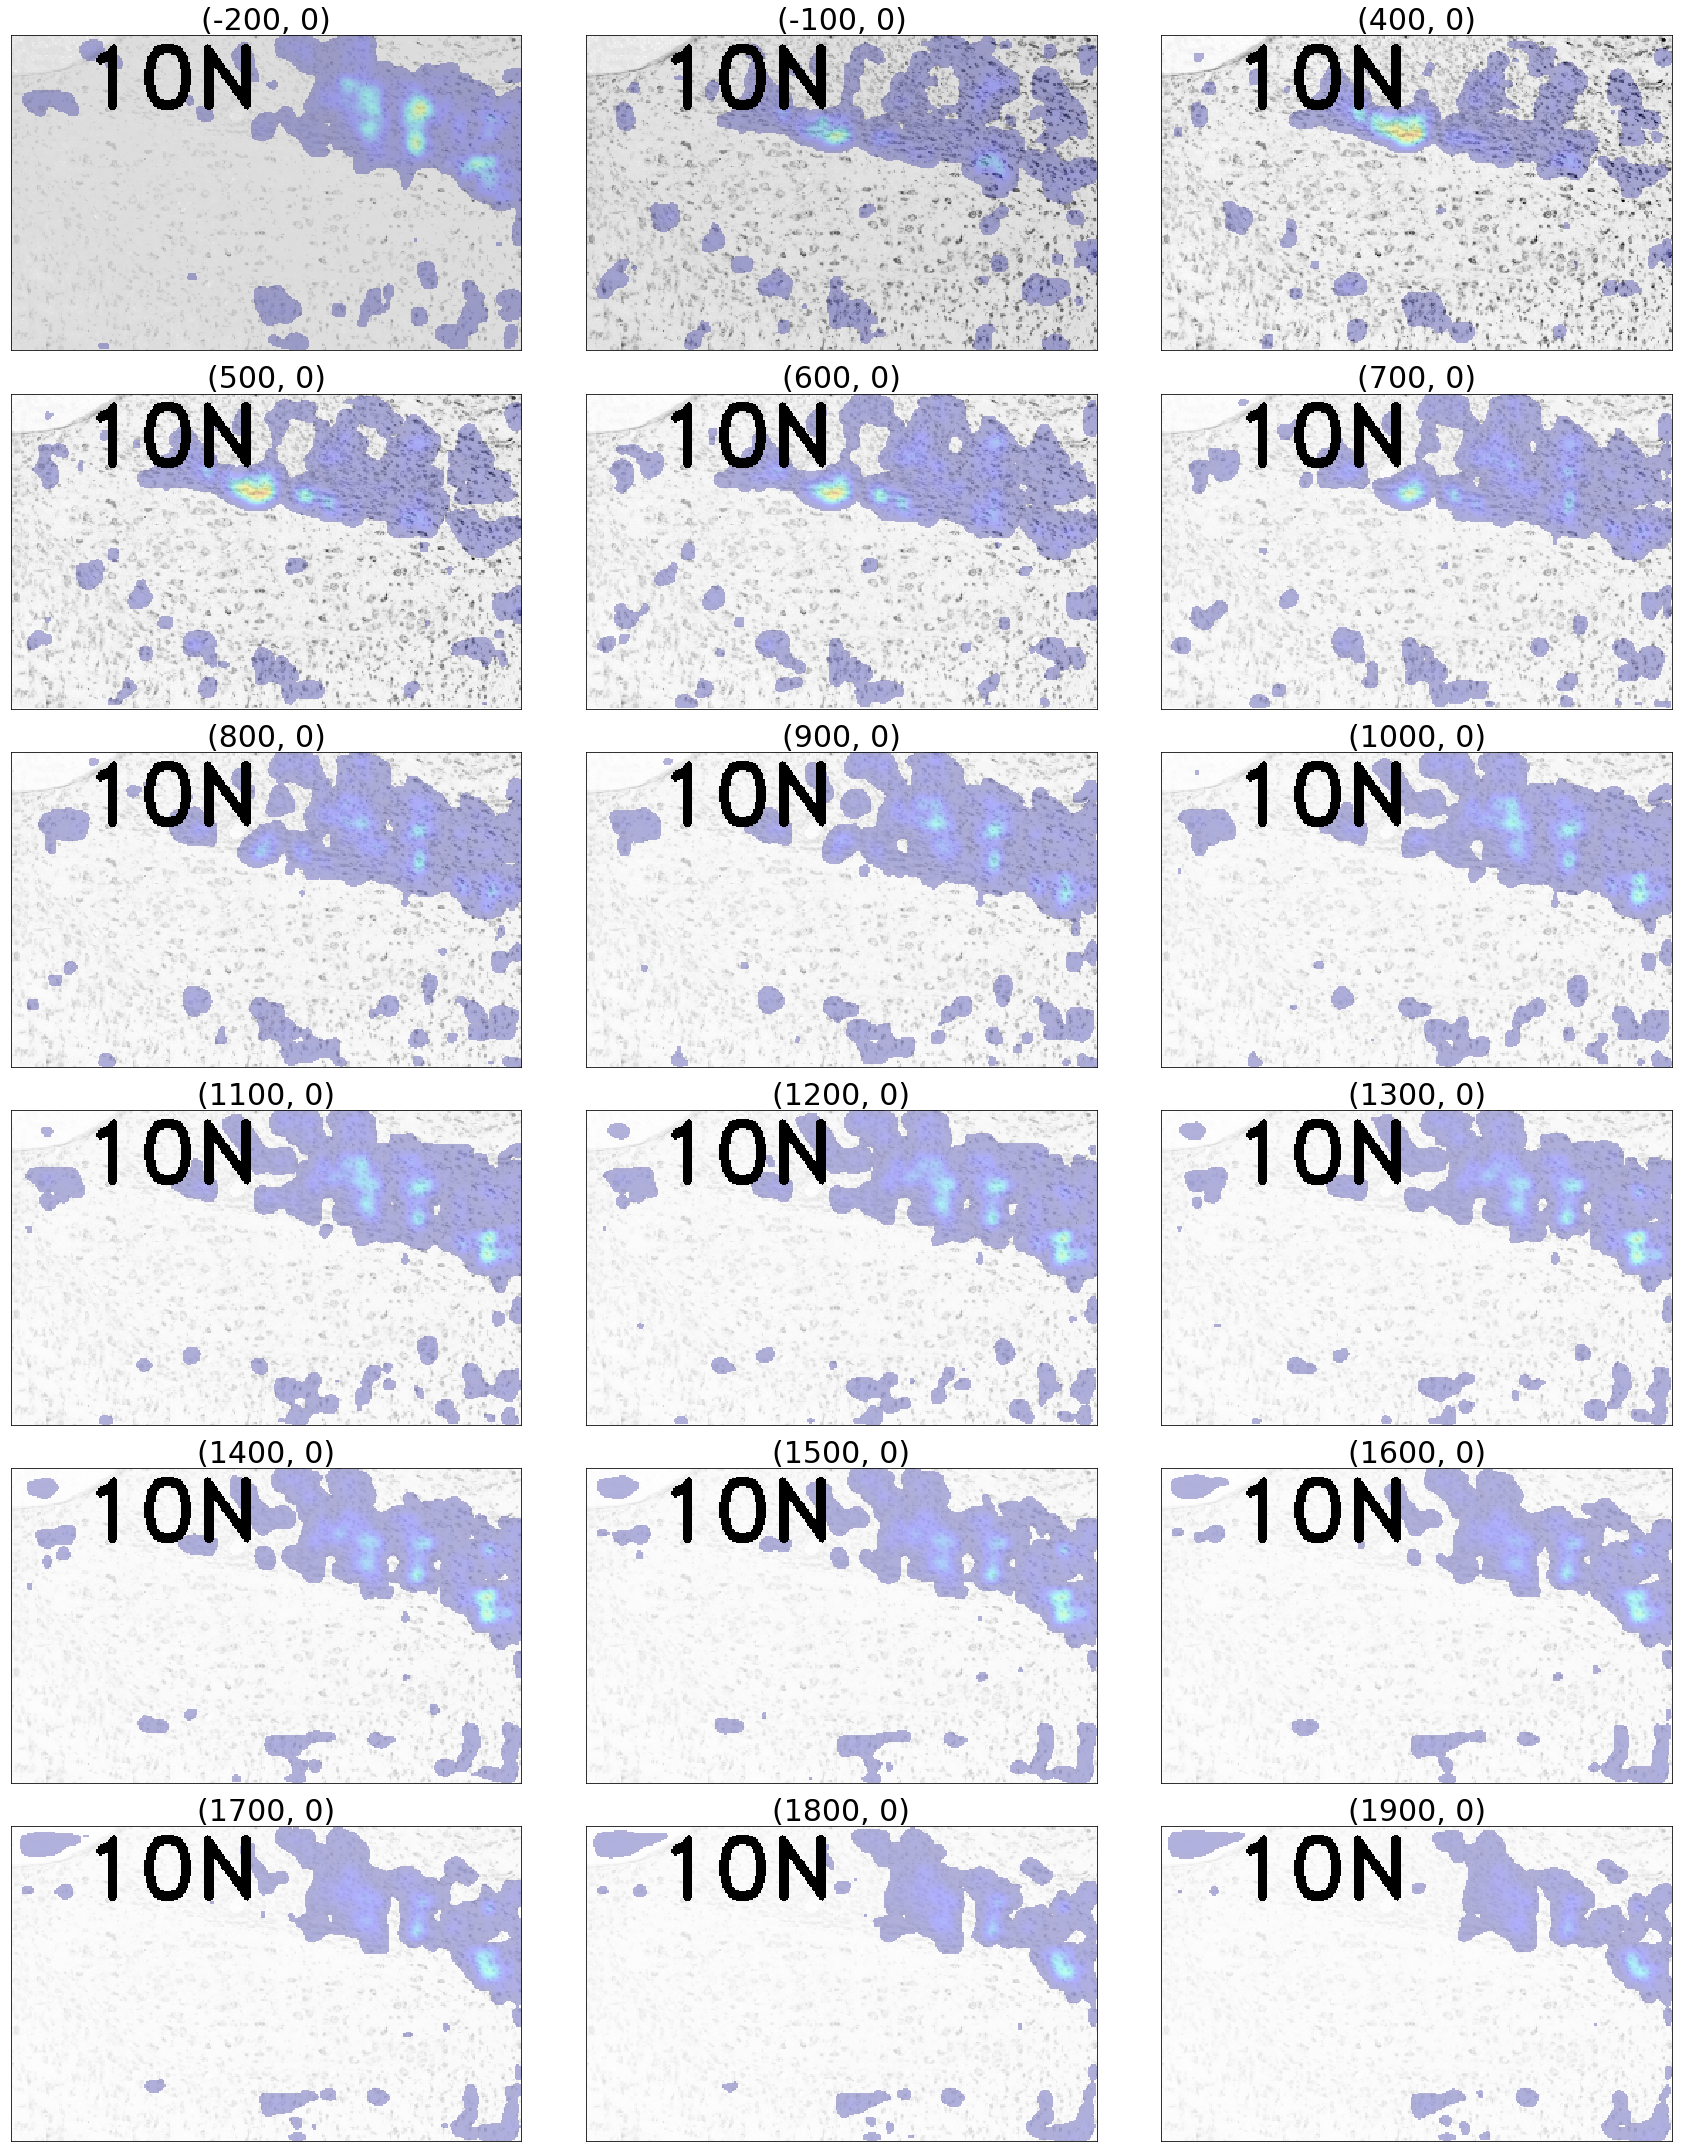

In [113]:
title_viz_tuples = [("%s" % str(scheme), vizs[structures[0]][(72, 'test_with_rot')])
 for scheme, x in sorted(scoremap_viz_allSchemes_allFns_allStructs_allConditions.items())
 for fn, vizs in x.iteritems()]

titles, vizs = zip(*title_viz_tuples)

display_images_in_grids(vizs=vizs, titles=titles, nc=3)

In [112]:
# vs = np.array([probs_allClasses_allVariations[v][structure] for v in variants])[:, ::100]

# plt.figure(figsize=(20,5));
# for v in variants:
#     plt.scatter(range(vs.shape[1]), vs[v]);

In [113]:
# for structure in structures:
#     plt.bar(variants, np.bincount(best_variation[structure], minlength=len(variants)))
#     plt.xlabel('Variant');

# Evaluate each scoremap

In [26]:
stack = 'MD661'
grid_index_class_lookup = DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=windowing_id,
                                                                             by_human=True)

In [27]:
def identify_positive_negative_grids(stack, sec, structure, grid_indices, neg_composition_rule):
    """
    Args:
        grid_indices (list of int): grid indices to query
        neg_composition_rule (str): e.g. surround200
    
    Returns:
        (list of boolean, list of boolean): is_pos, is_neg
    """
    
    global grid_index_class_lookup
    d = grid_index_class_lookup.loc[sec].dropna()
    labels_found = list(d.index)

    pos_classes = [structure]
    print 'pos_classes', pos_classes

    if neg_composition_rule.startswith('surround'):
        if neg_composition_rule == 'surround200':
            margin_um = 200
        elif neg_composition_rule == 'surround500':
            margin_um = 500
        elif neg_composition_rule == 'surround1000':
            margin_um = 1000
        else:
            margin_um = None
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in all_known_structures]
    elif neg_composition_rule == 'negative':
        neg_classes = [structure + '_negative']
    else:
        raise

    neg_classes = list(set(neg_classes) & set(labels_found))
    print 'neg_classes', neg_classes

    #####################################

    pos_grid_indices = np.concatenate([d[pos_class] for pos_class in pos_classes])
    neg_grid_indices = np.concatenate([d[neg_class] for neg_class in neg_classes])

    #####################################

    n = len(grid_indices) 

    is_pos = np.in1d(grid_indices, pos_grid_indices)
    is_neg = np.in1d(grid_indices, neg_grid_indices)
    return is_pos, is_neg

In [28]:
def evaluate_scoremap(stack=None, sec=None, structure=None, is_pos=None, is_neg=None,
                      grid_indices=None, scores=None, 
                      neg_composition_rule='surround500'):
    """
    Args:
        grids_to_scores (dict of {int: float}): a mapping from grid indices to scores.
        
    Returns:
        fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh      
    """
    
    if is_pos is None or is_neg is None:
        is_pos, is_neg = identify_positive_negative_grids(stack=stack, sec=sec, 
                                                          structure=structure, 
                                                          grid_indices=grid_indices,
                                                         neg_composition_rule=neg_composition_rule)
        
    n_pos = np.count_nonzero(is_pos)
    n_neg = np.count_nonzero(is_neg)
        
#     print n_pos, 'pos', n_neg, 'neg'
    
    scores_used = np.r_[scores[is_pos], scores[is_neg]]
    clf_labels = np.r_[np.ones((n_pos,)), -1*np.ones((n_neg,))]
    
    ######## PRECISION-RECALL ########
    precision_allthresh = {}
    recall_allthresh = {}
    f1score_allthresh = {}
    tp_allthresh = {}
    fp_allthresh = {}
    for th in np.arange(0., 1., 0.005):

        cm = compute_confusion_matrix(np.c_[scores_used, 1-scores_used], [0 if l==1. else 1 for l in clf_labels], 
                                      soft=False, normalize=False, binary=True, decision_thresh=th)

        tp = cm[0,0]
        fn = cm[0,1]
        fp = cm[1,0]
        tn = cm[1,1]
#         print th, int(tp), int(fn), int(fp), int(tn)

        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        
        beta = 1 # higher for more emphasis on recall
        f1score = (1+beta**2)*recall*precision/(recall+ beta**2*precision)

        fp_allthresh[th] = fp / (fp + tn)
        tp_allthresh[th] = tp / (tp + fn)
        
        precision_allthresh[th] = precision
        recall_allthresh[th] = recall
        f1score_allthresh[th] = f1score

    optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f1score_allthresh[th] for th in np.arange(0, 1, 0.01)])]            
    fopt = f1score_allthresh[optimal_th]
    
    return fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh
# pos_grid_indices, neg_grid_indices

In [29]:
sec = metadata_cache['filenames_to_sections'][stack][fn]

## Multiple intensity correction schemes

In [30]:
is_pos, is_neg = identify_positive_negative_grids(stack=stack, sec=sec, 
                                                  structure=structure,
                                                  grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                                                  neg_composition_rule='surround500')

pos_classes ['10N']
neg_classes ['10N_surround_500_noclass', '10N_surround_500_AP', '10N_surround_500_12N']


In [31]:
intensity_to_color = {intens: np.array(random_colors(1)[0])/255. for intens in intensity_ranges}
classifier_to_color = {clf_id: np.array(random_colors(1)[0])/255. for clf_id in [72,73,74,75]}

In [66]:
conditions = [(72, 'test_with_rot')]
#               (73, 'test_with_rot')]

In [60]:
evaluation_results_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

(72, 'test_with_rot') max_int 0.199191102123 0.92


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


(72, 'test_with_rot') (400, 0) 0.0954166666667 0.01
(72, 'test_with_rot') (500, 0) 0.117084826762 0.01
(72, 'test_with_rot') (600, 0) 0.141220357048 0.05
(72, 'test_with_rot') (700, 0) 0.170316301703 0.12
(72, 'test_with_rot') (800, 0) 0.173372348208 0.08
(72, 'test_with_rot') (900, 0) 0.169517293805 0.05
(72, 'test_with_rot') (1000, 0) 0.160660660661 0.21
(72, 'test_with_rot') (1100, 0) 0.154939587775 0.12


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


(72, 'test_with_rot') (1200, 0) 0.164136622391 0.03
(72, 'test_with_rot') (1300, 0) 0.181704260652 0.05
(72, 'test_with_rot') (1400, 0) 0.207092198582 0.06
(72, 'test_with_rot') (1500, 0) 0.249042145594 0.12
(72, 'test_with_rot') (1600, 0) 0.278538812785 0.18
(72, 'test_with_rot') (1700, 0) 0.306196840826 0.2
(72, 'test_with_rot') (1800, 0) 0.328795811518 0.13
(72, 'test_with_rot') (1900, 0) 0.344086021505 0.16
(72, 'test_with_rot') (-100, 0) 0.21029082774 0.92
(72, 'test_with_rot') (-200, 0) 0.232317423807 0.5


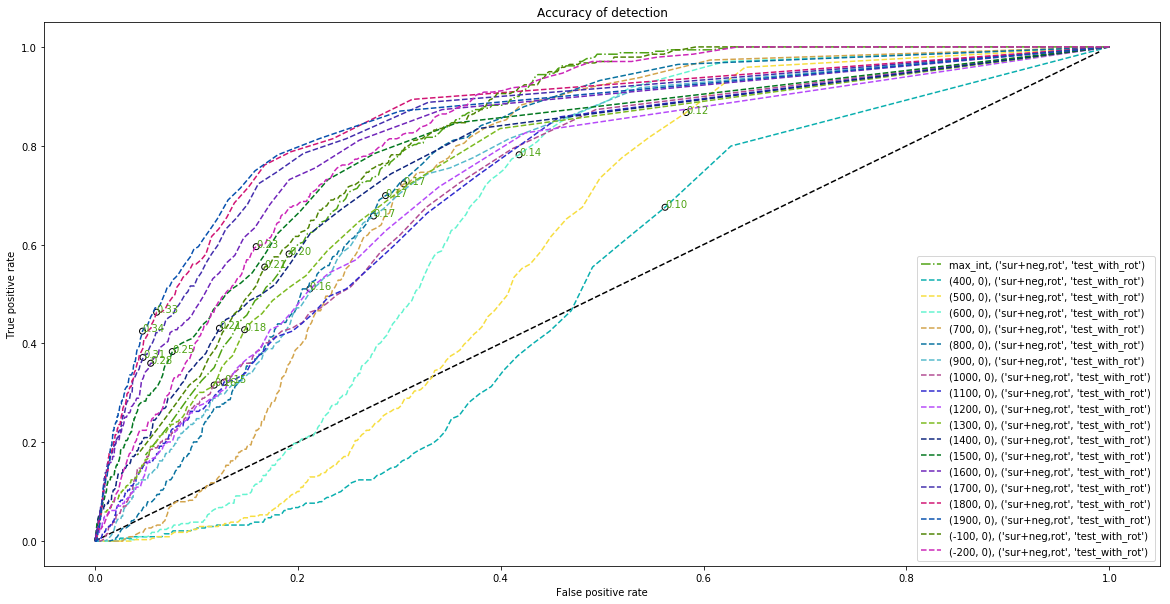

In [61]:
plt.figure(figsize=(20, 10));
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

for cond in conditions:
        
    fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh = \
    evaluate_scoremap(grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                      scores=best_sparse_scores[cond],
                     is_pos=is_pos, is_neg=is_neg)

    print cond, 'max_int', fopt, optimal_th

    if cond[1] == 'test_no_rot':
        linestyle = ':'
    elif cond[1] == 'test_with_rot':
        linestyle = '-.'
    else:
        raise

    if cond[0] == 72:
        clf_str = 'sur+neg,rot'
    elif cond[0] == 73:
        clf_str = 'sur,rot'
    elif cond[0] == 74:
        clf_str = 'sur,rot+int'
    elif cond[0] == 75:
        clf_str = 'sur+neg,rot+int'
    else:
        raise

    plt.plot([fp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                 [tp_allthresh[th] for th in np.arange(0, 1, 0.005)],
            label='%s, %s'%('max_int', str((clf_str,cond[1]))), 
             c=classifier_to_color[cond[0]], linestyle=linestyle);

    plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
                marker='o', facecolors='none', edgecolors='k')

    plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%.2f' % (fopt), 
             color=classifier_to_color[cond[0]])

    ###############
    
#     for intensity_range in [(-200, 0), (-100, 0), (1900, 0)]:
    for intensity_range in intensity_ranges:

        evaluation_results_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond] = \
        evaluate_scoremap(grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                          scores=sparse_scores_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond],
                         is_pos=is_pos, is_neg=is_neg)

        fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh = \
        evaluation_results_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond]

        print cond, intensity_range, fopt, optimal_th

        if cond[1] == 'test_no_rot':
            linestyle = '-'
        elif cond[1] == 'test_with_rot':
            linestyle = '--'
        else:
            raise

        if cond[0] == 72:
            clf_str = 'sur+neg,rot'
        elif cond[0] == 73:
            clf_str = 'sur,rot'
        elif cond[0] == 74:
            clf_str = 'sur,rot+int'
        elif cond[0] == 75:
            clf_str = 'sur+neg,rot+int'
        else:
            raise

        plt.plot([fp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                     [tp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                label='%s, %s'%(str(intensity_range), str((clf_str,cond[1]))), 
#                  c=classifier_to_color[cond[0]], 
                 c=intensity_to_color[intensity_range], 
                 linestyle=linestyle);

        plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
                    marker='o', facecolors='none', edgecolors='k')

        plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%.2f' % (fopt), color=classifier_to_color[cond[0]])

evaluation_results_allSchemes_allFns_allStructs_allConditions.default_factory = None

plt.legend();
# plt.axis('equal');
plt.ylabel('True positive rate');
plt.xlabel('False positive rate');
plt.title('Accuracy of detection');
plt.show();

In [71]:
thresholds_allConditions_allSchemes = defaultdict(dict)
for cond in conditions:
    for intens in intensity_ranges:
        thresholds_allConditions_allSchemes[cond][intens] = evaluation_results_allSchemes_allFns_allStructs_allConditions[intens][fn][structure][cond][1]

In [72]:
downscale = 32
img_blue_intensity_normalized = {}

for fn in filenames:
    
    for intens in intensity_ranges:
        low, high = intens
        if low == -100:
            intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
            download_from_s3(intensity_mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(intensity_mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)].astype(np.int)].astype(np.uint8)
        elif low == -200:
            intensity_mapping_ntb_to_nissl = np.loadtxt('/tmp/ntb_to_nissl_mapping.npy')
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)].astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized[intens] = rescale_intensity_v2(img_blue[roi_ymin:(roi_ymin+roi_h),
                                                                           roi_xmin:(roi_xmin+roi_w)], low, high)
    
    for structure in structures:
        for intens in intensity_ranges:
            for cond in conditions:

                def resample_scoremap(fn, s):
                    
                    downscaled_grid_y = np.arange(0, h, downscale)
                    downscaled_grid_x = np.arange(0, w, downscale)
                    downscaled_ny = len(downscaled_grid_y)
                    downscaled_nx = len(downscaled_grid_x)

                    sparse_scores = sparse_scores_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] 

                    f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                    a = (sample_locations_roi - half_size)/spacing
                    f_grid[a[:,1], a[:,0]] = sparse_scores

                    yinterps = (downscaled_grid_y - half_size)/float(spacing)
                    xinterps = (downscaled_grid_x - half_size)/float(spacing)

                    points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                    coord = np.c_[points_y.flat, points_x.flat]
                    f_interp = map_coordinates(f_grid, coord.T, order=1)
                    f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                    scoremap = f_interp_2d.astype(np.float16)
                        
                    return scoremap

#                 t = time.time()
#                 scoremap = resample_scoremap(fn, structure)
                scoremap = resample_scoremap(fn, structure) > thresholds_allConditions_allSchemes[cond][intens]
    
                #         pool = Pool(NUM_CORES/2)
                #         # pool = Pool(1)
                #         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
                #         pool.close()
                #         pool.join()
#                 sys.stderr.write('Resample scoremap: %.2f seconds\n' % (time.time() - t)) 

                #########################
    
                def save_scoremap(structure):
                    scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[intens], 
                                                       in_downscale=1, stack=stack, fn=fn, structure=structure,
                                                       scoremap=scoremap[roi_ymin/32:(roi_ymin+roi_h)/32,
                                                                           roi_xmin/32:(roi_xmin+roi_w)/32],
                                                      in_scoremap_downscale=32,
                                                      out_downscale=8, label_text=str(structure), 
                                                      cmap_name= 'jet')
                #         pool = Pool(NUM_CORES)
                #         structures = scoremaps_allClasses.keys()
                #         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
                #         pool.close()
                #         pool.join()
                    return scoremap_viz

                t = time.time()

                for s in structures:
                    scoremap_viz_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] = save_scoremap(s)

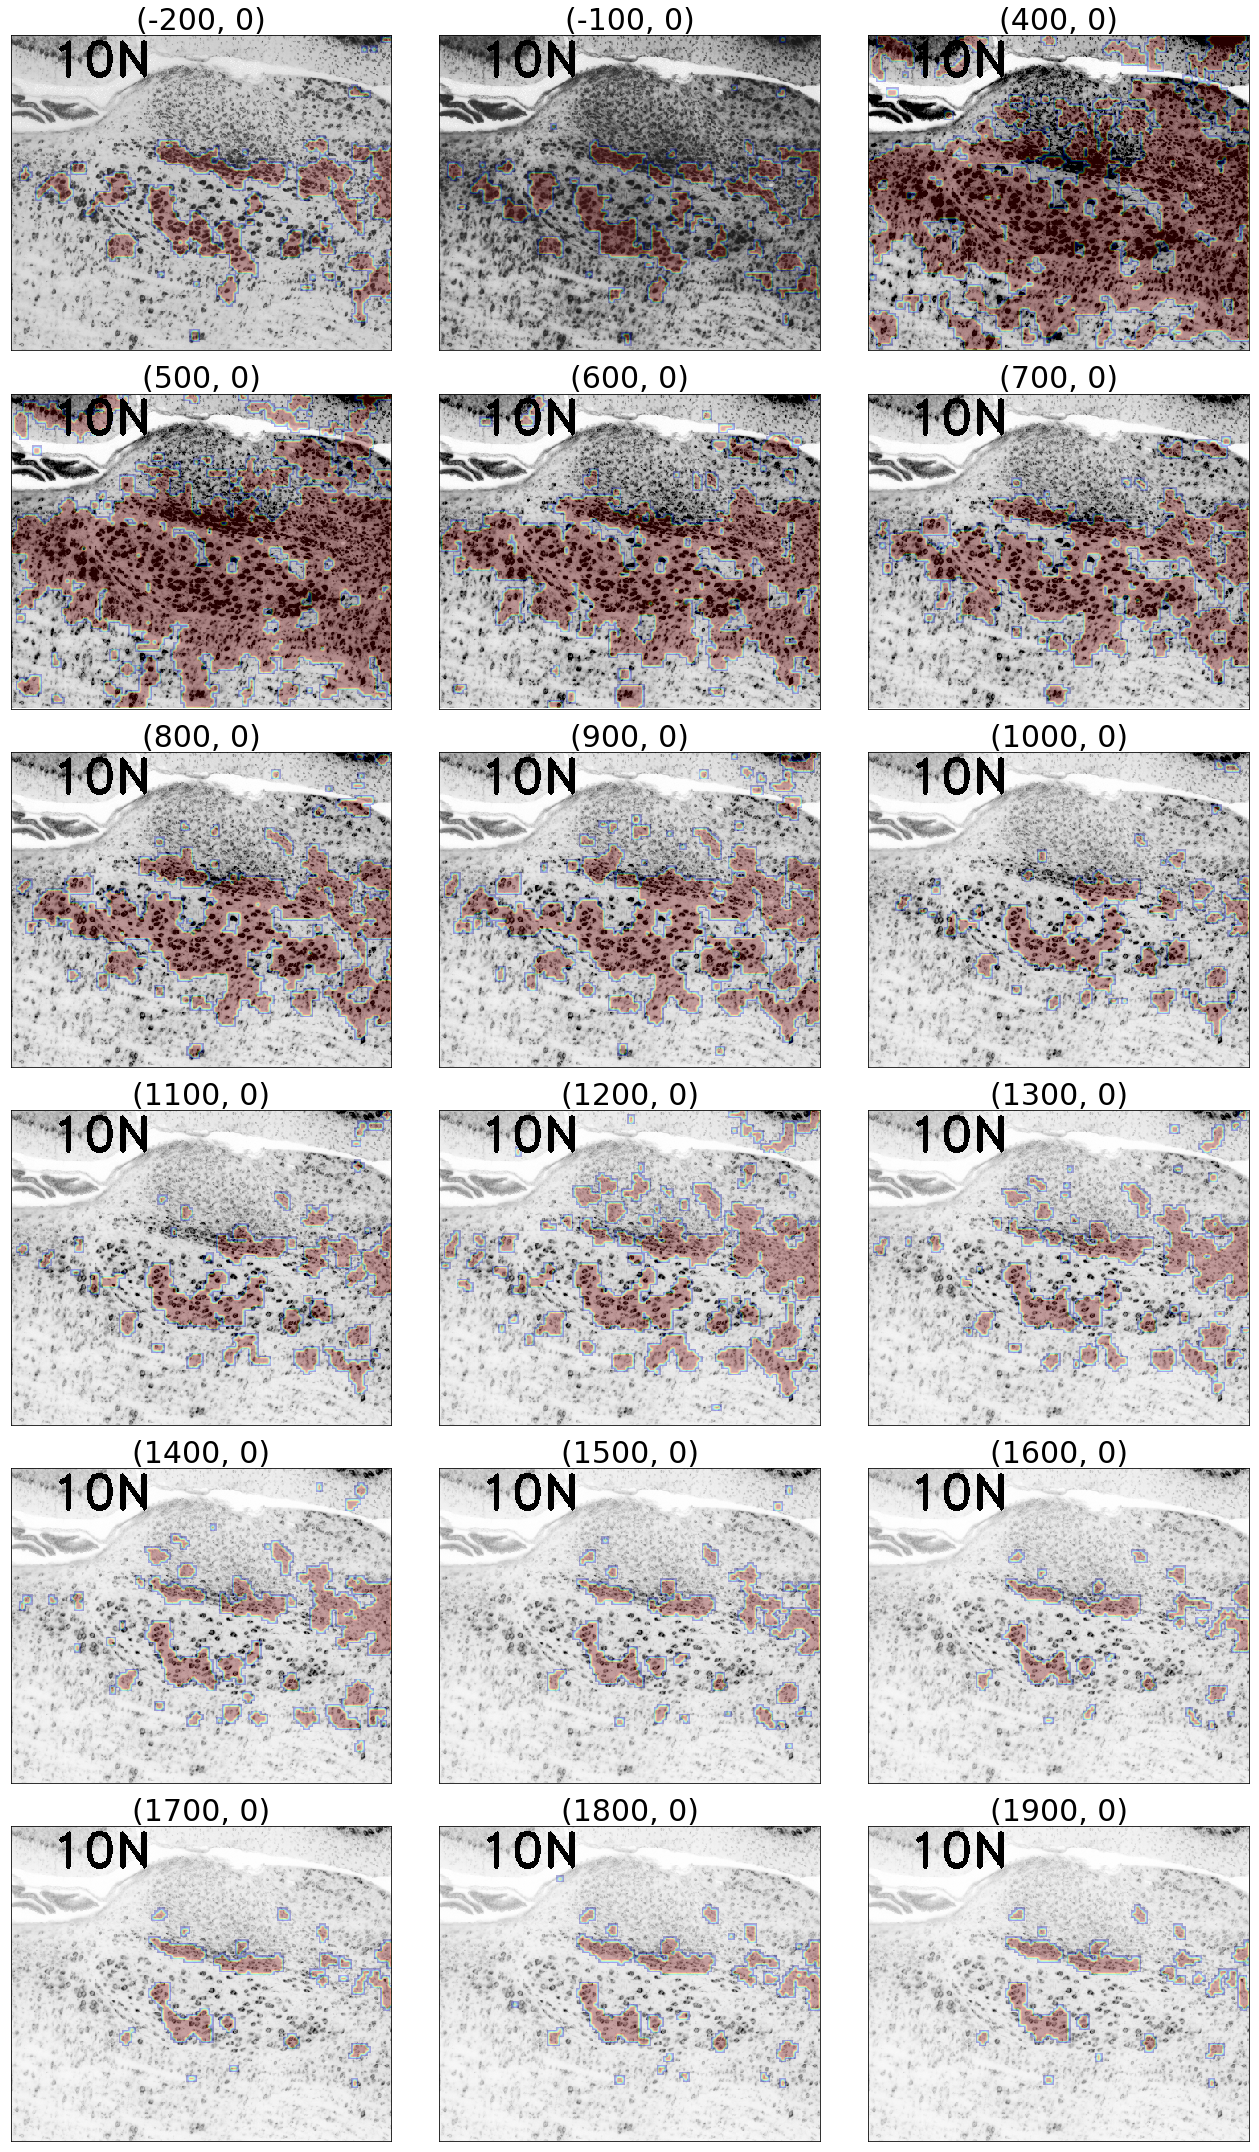

In [73]:
title_viz_tuples = [("%s" % str(scheme), vizs[structures[0]][(72, 'test_with_rot')])
 for scheme, x in sorted(scoremap_viz_allSchemes_allFns_allStructs_allConditions.items())
 for fn, vizs in x.iteritems()]

titles, vizs = zip(*title_viz_tuples)

display_images_in_grids(vizs=vizs, titles=titles, nc=3)

- Train using sur or sur+neg is similar.
- Train using both rotation and intensity variation is clearly worse than train using rotation variation only.
- Test using varying rotation always improves performance.
- Test using varying rotation and varying intensity does not have clear advantage over using varying rotation only.
- For small false positive rates, max_int slightly worse than default-matched scheme. For large false positive rates, max_int is slightly better. If scheme is not matched well, max_int is definitely better.

In [ ]:
plt.figure(figsize=(10, 10));

for low, hi in sorted(sparse_scores_allSchemes_allFns_allStructs.keys()):
    fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh = \
    evaluate_scoremap(grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                      scores=sparse_scores_allSchemes_allFns_allStructs[(low, hi)][fn][structure],
                     is_pos=is_pos, is_neg=is_neg)

    print low, hi, fopt, optimal_th

    plt.plot([fp_allthresh[th] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[th] for th in np.arange(0, 1, 0.01)],
            label='low=%d'%low, c=np.array(random_colors(1)[0])/255.);

    plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
                marker='o', facecolors='none', edgecolors='k')
    
#     plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%d(%.2f)' % (low, fopt))
    plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%d' % (low))

plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');
    
plt.legend();
plt.axis('equal');
plt.ylabel('True positive rate');
plt.xlabel('False positive rate');
plt.title('');
plt.show();

In [71]:
# viz = scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn][structure].copy()
# for x, y in sample_locations[pos_grid_indices] - (roi_xmin, roi_ymin):
#     cv2.circle(viz, (x/8,y/8), 1, color=(255,0,0))
# for x, y in sample_locations[neg_grid_indices] - (roi_xmin, roi_ymin):
#     cv2.circle(viz, (x/8,y/8), 1, color=(0,255,0))
# display_image(viz)